
## Inter-Subject Correlation and Inter-Subject Functional Correlation 

The functional connectivity methods that we used in previous notebooks compared time series of BOLD activity between voxels within participant to infer how different regions of the brain were interacting. However, BOLD activity contains multiple components ([Figure 1a](#fig1)):
1. Task-based/stimulus-evoked signal that is reliable across participants.
2. Intrinsic fluctuations in neural activity that are participant-specific.
3. Scanner or physiological noise that can be either shared or participant-specific.

In this notebook, we will consider methods that combine data across participants to eliminate #2 and #3 when calculating fMRI reliability (intersubject correlation or ISC, [Hasson et al., 2004](https://doi.org/10.1126/science.1089506)) and connectivity (intersubject functional correlation or ISFC, [Simony et al., 2016](https://doi.org/10.1038/ncomms12141)). ISC and ISFC help isolate #1 because it is the only component that ought to be shared across participants.

[Figure 1b,c](#fig1) show how ISC differs from functional connectivity: rather than correlating brain regions, which preserves participant-specific activity and noise, ISC correlates between the brains of different participants in order to capture only the activity that is shared. In ISC, this correlation is done for every voxel in the brain to the matching voxel in other brains, producing a full brain map. [Figure 1e](#fig1) shows this as the diagonal of a correlation matrix, where each cell corresponds to a voxel in subject X correlated with the same anatomical voxel in subject Y. In practice, to simplify the computation and the interpretation it is typical for ISC to compare each individual participant with the average of all other participants.

[Figure 1d](#fig1) shows ISFC: the correlation of every voxel in one participant with every other voxel in another participant (or average of other participants). This is like FCMA except it is between participants rather than within participants. In fact, these analyses use the same computational tricks. ISFC is valuable because it allows us to identify activity coupling in voxels that are not aligned across participants: the off diagonal in [Figure 1e](#fig1) represents correlations for voxels in different parts of the brain.

<a id="fig1"></a>![image](https://media.springernature.com/full/springer-static/image/art%3A10.1038%2Fncomms12141/MediaObjects/41467_2016_Article_BFncomms12141_Fig1_HTML.jpg?as=webp)

We will use ISC and ISFC to identify brain regions that respond preferentially to narrative stories, rather than to a random assortment of words (replicating Simony et al., 2016). Furthermore, seed-based connectivity analysis does not show differences between resting state, random words, and intact narratives, but ISFC does distinguish between these conditions (Simony et al., 2016). Thus, ISFC shows greater sensitivity to the task than seed-based functional connectivity. 

## Goal of this script
1. To run intersubject correlation (ISC).
2. To run intersubject functional correlation (ISFC).  
3. Use ISFC to examine how a network of brain regions that respond to narrative stimuli.  
 

## Table of Contents

[1. The ISC-ISFC Workflow](#isc_isfc_wkflow)  

[2. ISC](#isc)
>[2.1 The "Pieman" data](#dataset)  
>[2.2 Data file preparation](#data_prep_isc)  
>[2.3 Compute ISC](#isc_compute)  
>[2.4 ISC with statistical tests](#isc_stats)  

[3. ISFC](#isfc)
>[3.1 Parcel the data](#isfc_parcel)   
>[3.2 Compute FC and ISFC](#fc_isfc)

[4. Spatial Correlation](#spat_corr)
>[4.1 Spatial inter-subject correlation](#spatial_isc)  

#### Exercises
>[1](#ex1)   [2](#ex2)  [3](#ex3)  [4](#ex4)  [5](#ex5)  [6](#ex6)  [7](#ex7)  [8](#ex8)   [9](#ex9)  
>[Novel contribution](#novel)  


## 1. The ISC-ISFC workflow  <a id="isc_isfc_wkflow"></a>


The following sequence of steps are recommended for successfully running ISC and ISFC using [BrainIAK](http://brainiak.org/). 

1. **Data Preparation:** Organize a data directory with fMRI subject data that you want to process. All subjects must be in the same anatomical space for analysis. You also need a whole-brain mask. After data preparation, you will have an array of anatomically-aligned and temporally-aligned brain data.
        
2. **Compute ISC:**  Compute correlations across subjects for corresponding voxels in the mask using the [ISC function](https://brainiak.org/docs/brainiak.html#brainiak.isc.isc). It uses the `compute_correlation` function in [BrainIAK](https://brainiak.org/docs/brainiak.fcma.html#brainiak.fcma.util.compute_correlation), which is optimized for fast execution (and was used in FCMA).

3. **Permutation Test for ISC:** Perform statistical analysis to determine significant correlation values for ISC.

4. **Compute ISFC:** The ISFC function computes correlations for every voxel in one subject with every other voxel averaged across subjects.

5. **Cluster the ISFC results:** Create clusters based on the correlation values. 

6. **Perform ISFC permutation:** Perform permutation tests to determine the significance of the results.

In [1]:
import warnings
import sys 
if not sys.warnoptions:
    warnings.simplefilter("ignore")
import os 
import glob
import time
from copy import deepcopy
import numpy as np
import pandas as pd 

from nilearn import datasets
from nilearn import surface
from nilearn import plotting
from nilearn.input_data import NiftiMasker, NiftiLabelsMasker
import nibabel as nib

from brainiak import image, io
from brainiak.isc import isc, isfc, permutation_isc
import matplotlib.pyplot as plt
import seaborn as sns 

sns.set(style = 'white', context='notebook', font_scale=1, rc={"lines.linewidth": 2})

## 2. ISC  <a id="isc"></a>

### 2.1 The "Pieman" data  <a id="dataset"></a>

For this script we will use the "Pieman" dataset from [Simony et al. (2016)](https://doi.org/10.1038/ncomms12141). A description of the dataset is as follows:

>18 native English speakers were scanned (15 females, ages: 18–31), corresponding to the replication dataset from the Pieman study.  
>Stimuli for the experiment were generated from a 7 min real life story (["Pie Man", Jim O'Grady](https://www.youtube.com/watch?v=3nZzSUDECLo)) recorded at a live storytelling performance (["The Moth" storytelling event](https://themoth.org/), New York City). Subjects listened to the story from beginning to end (intact condition).
>In addition, subjects listened to scrambled versions of the story, which were generated by dividing the original stimulus into segments of different timescales (paragraphs and words) and then permuting the order of these segments. To generate the scrambled stimuli, the story was segmented manually by identifying the end points of each word and paragraph. Two adjacent short words were assigned to a single segment in cases where we could not separate them. Following segmentation, the intact story was scrambled at two timescales: short—‘words’ (W; 608 words, 0.7±0.5 s each) and long—‘paragraphs’ (P; 11 paragraphs, 38.1±17.6 s each). Laughter and applause were classified as single word events (4.4% of the words). Twelve seconds of neutral music and 3 s of silence preceded, and 15 s of silence followed, each playback in all conditions. These music and silence periods were discarded from all analyses.

More details about the experiment may be accessed in the methods section of the paper.

### 2.2 Data File Preparation <a id="data_prep_isc"></a>


**Loading and preparing the data:**

BrainIAK has methods to efficiently load data. We have used some of these functions in previous notebooks.

> [load_images](https://brainiak.org/docs/brainiak.html#brainiak.isc.isc): reads data from all subjects in a list that you provide. 

> [load_boolean_mask](https://brainiak.org/docs/brainiak.html#brainiak.io.load_boolean_mask): Create a binary mask from a brain volume.

> [mask_images](https://brainiak.org/docs/brainiak.html#brainiak.image.mask_images): Loads the brain images and masks them with the mask provided.

> [image.MaskedMultiSubjectData.from_masked_images](https://brainiak.org/docs/brainiak.html?highlight=image%20maskedmultisubjectdata%20from_masked_images#brainiak.image.MaskedMultiSubjectData.from_masked_images): Creates a list of arrays, with each item in the list corresponding to one subject's data. This data format is accepted by the BrainIAK ISC and ISFC function.

In [2]:
# Set up experiment metadata

from utils import pieman2_dir, results_path
print(f'Data directory is: {pieman2_dir}')

dir_mask = os.path.join(pieman2_dir, 'masks')
mask_name = os.path.join(dir_mask, 'avg152T1_gray_3mm.nii.gz')
all_task_names = ['intact1','word']
all_task_des = ['intact story','word level scramble']
n_subjs_total = 18
group_assignment_dict = {task_name: i for i, task_name in enumerate(all_task_names)}

# Where do you want to store the data
dir_out = f'{results_path}/isc/'
if not os.path.exists(dir_out):
    os.makedirs(dir_out)
    print(f'Dir {dir_out} created.')

Data directory is: /gpfs/gibbs/project/cmhn/data/Pieman2/


### Helper functions

We provide helper functions to load the data.

<div class="alert alert-block alert-warning">
<strong>Memory limits</strong> Be aware that running this on all 18 participants may push the limits of your memory and computational resources. We will only use half of the subjects for now, but you are encouraged to try to run on all subjects for your novel contribution if you choose to.
</div>

In [3]:
# Reduce the number of subjects per condition to make this notebook faster 
upper_limit_n_subjs = 9

def get_file_names(data_dir, task_name, verbose = False):
    """
    Get all the participant file names
    
    Parameters
    ----------
    data_dir [str]: the data root dir
    task_name [str]: the name of the task 
    
    Return
    ----------
    fnames [list]: file names for all subjs
    """
    fnames = []
    # Collect all file names 
    for subj in range(1, n_subjs_total): 
        fname = f'{data_dir}/sub-{subj:03d}/func/sub-{subj:03d}-task-{task_name}.nii'
        
        # If the file exists
        if os.path.exists(fname):
            # Add to the list of file names 
            fnames.append(fname)
            if verbose: print(fname) 
        if len(fnames) >= upper_limit_n_subjs:  break
           
    return fnames

In [4]:
# Load the brain mask
brain_mask = io.load_boolean_mask(mask_name)

# Get the list of nonzero voxel coordinates
coords = np.where(brain_mask)

# Load the brain nii image
brain_nii = nib.load(mask_name) 

# Load BOLD data 
fnames = {}
images = {}
masked_images = {}
bold = {}
group_assignment = []
n_subjs = {}

for task_name in all_task_names: 
    # Load all the filenames for this task.
    fnames[task_name] = get_file_names(pieman2_dir, task_name)
    # Load all the images from those filenames.
    images[task_name] = io.load_images(fnames[task_name]) 
    # Mask the images.
    masked_images[task_name] = image.mask_images(images[task_name], brain_mask) 
    
    # Concatenate all of the masked images across participants  
    bold[task_name] = image.MaskedMultiSubjectData.from_masked_images(
        masked_images[task_name], len(fnames[task_name])
    )
    
    # Convert nans into zeros.
    np.nan_to_num(bold[task_name], copy=False)
    
    # Compute the group assignment label.
    n_subjs_this_task = np.shape(bold[task_name])[-1]
    group_assignment += list(
        np.repeat(group_assignment_dict[task_name], n_subjs_this_task)
    )
    n_subjs[task_name] = n_subjs_this_task
    print(f'Data loaded: {task_name} \t shape: {np.shape(bold[task_name])}')

Data loaded: intact1 	 shape: (300, 98508, 9)
Data loaded: word 	 shape: (300, 98508, 9)


**Exercise 1:**<a id="ex1"></a> Inspect the data you just loaded and answer and report on the following details.<br>
a. Report the shapes of `brain_nii` and `brain_mask`. How many voxels are in the brain mask? <br>
b. Visualize `brain_nii` and `brain_mask` by plotting the 30th slice along the Z dimension. Make sure to title these plots. What's the difference between `brain_nii` and `brain_mask`?<br>
c. Describe what `coords` means.<br> 
d. Visualize `coords` with a 3d plot. For this, only plot every 10th point, otherwise the plot will be slow to load.<br> 
e. Inspect the shape of `bold`. How many subjects do we have for each task condition? Do different subjects have the same number of TRs/voxels?<br>

In [5]:
# Insert code below
print(brain_nii.shape)
print(brain_mask.shape)

(61, 73, 61)
(61, 73, 61)


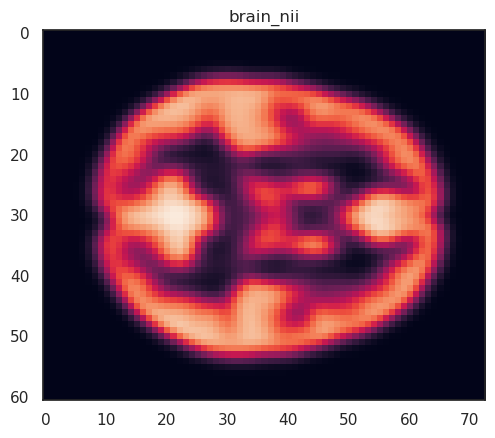

In [6]:
niislice = brain_nii.dataobj[:, :, 30]
plt.imshow(niislice)
plt.title('brain_nii');

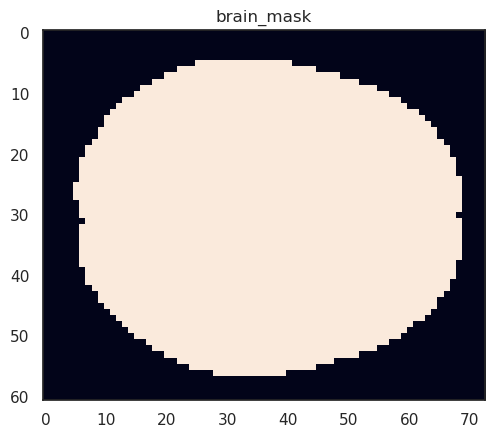

In [7]:
maskslice = brain_mask[:, :, 30]
plt.imshow(maskslice)
plt.title('brain_mask');

brain_nii is an anatomical representation of a brain with the grey matter being warmer on a heat map. brain_mask is just a mask of the volume occupied by the brain as a whole.

Coords is a set of all the coordinates of the voxels that compose the brain mask.

In [8]:
voxcoords = [[x, y, z] for x, y, z in zip(coords[0], coords[1], coords[2])]

# print(voxcoords)

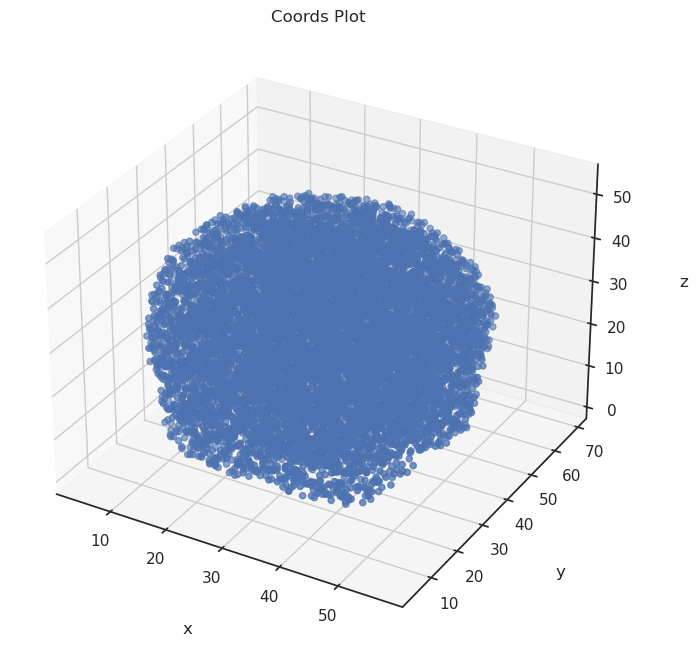

In [9]:
fig = plt.figure(figsize = (8,8))
ax = plt.axes(projection='3d')
ax.grid()
x = coords[0][::10]
y = coords[1][::10]
z = coords[2][::10]

ax.scatter(x, y, z)
ax.set_title('Coords Plot')

# Set axes label
ax.set_xlabel('x', labelpad=20)
ax.set_ylabel('y', labelpad=20)
ax.set_zlabel('z', labelpad=20)

plt.show()

In [10]:
bold['intact1'].shape

(300, 98508, 9)

In [11]:
bold['word'].shape

(300, 98508, 9)

There are 9 subjects, 98508 voxels, and 300 TRs for each task condition.

### 2.3 Compute ISC <a id="isc_compute"></a>

ISC is the correlation of each voxel's time series for a participant with the corresponding (anatomically aligned) voxel time series in the average of the other participants' brains. BrainIAK has functions for computing ISC by feeding in the concatenated participant data. 

This will take about 10 minutes to complete.

In [12]:
# run ISC, loop over conditions 
isc_maps = {}
for task_name in all_task_names:
    isc_maps[task_name] = isc(bold[task_name], pairwise=False) # setting pairwise to false means it does leave-one-subject-out
    print(f'Shape of {task_name} condition: {np.shape(isc_maps[task_name])}')

Shape of intact1 condition: (9, 98508)
Shape of word condition: (9, 98508)


The output of ISC is a voxel by participant matrix (showing the result of each individual with the group). Below we will visualize the ISC matrix for one participant and condition back on to the brain to see where activity is correlated between participants.

In [13]:
# set params 
subj_id = 0
task_name = 'intact1'
save_data = False

# Make the ISC output a volume
isc_vol = np.zeros(brain_nii.shape)
# Map the ISC data for the first participant into brain space
isc_vol[coords] = isc_maps[task_name][subj_id, :]
# make a nii image of the isc map 
isc_nifti = nib.Nifti1Image(isc_vol, brain_nii.affine, brain_nii.header)

# Save the ISC data as a volume (This is sample code for later, if you don't want to rerun the analysis!)
if save_data: 
    isc_map_path = os.path.join(dir_out, f'ISC_{task_name}_sub{subj_id:02d}.nii.gz')
    nib.save(isc_nifti, isc_map_path)

Text(0.5, 1.0, 'ISC map for subject 1, task = intact1')

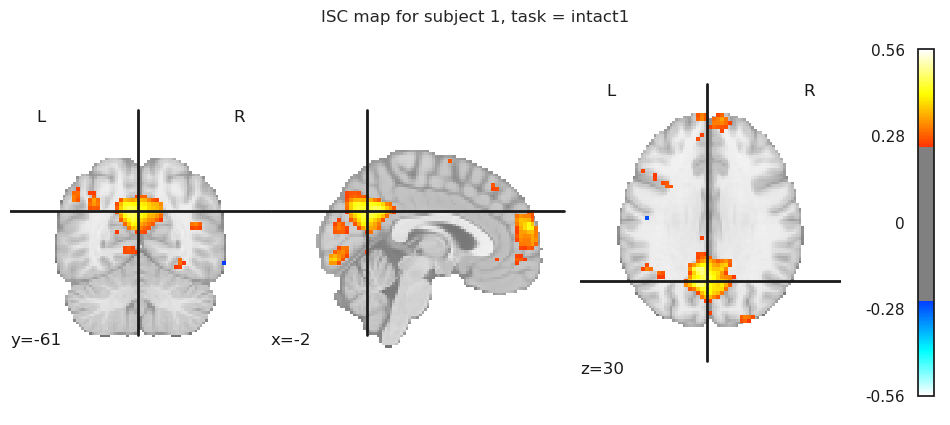

In [14]:
# Plot the data as a statmap
threshold = .25

f, ax = plt.subplots(1,1, figsize = (12, 5))
plotting.plot_stat_map(
    isc_nifti, 
    threshold=threshold, 
    axes=ax
)
ax.set_title(f'ISC map for subject {subj_id+1}, task = {task_name}') 

**Exercise 2:** <a id="ex2"></a> Caluclate the averaged ISC map across participants for each task. Visualize these maps showing the same xyz cut, threshold, and vmax. 

Text(0.5, 1.0, 'AVG ISC, task = word')

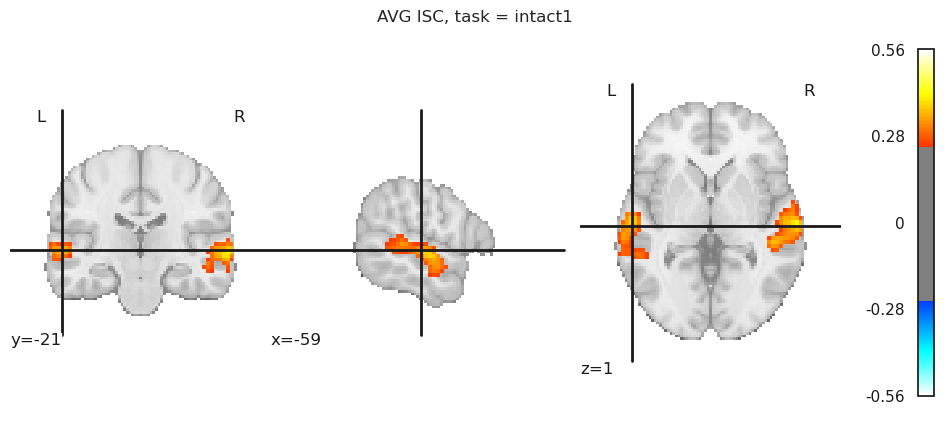

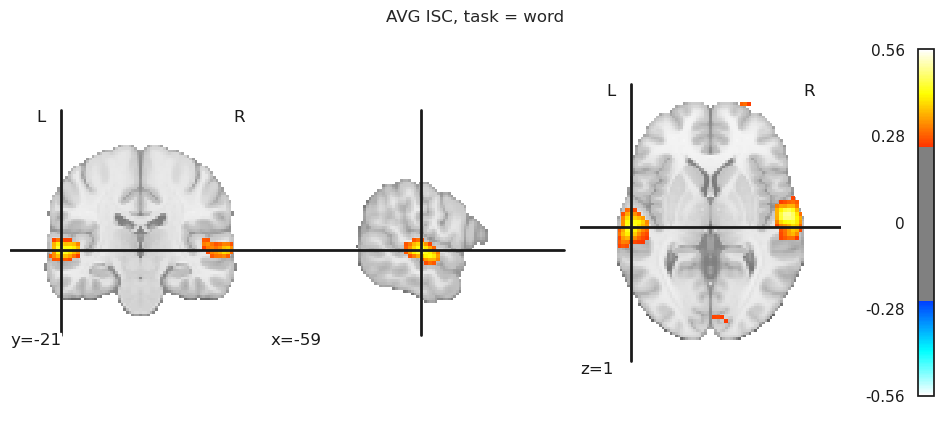

In [15]:
task_name = 'intact1'
save_data = False


isc_vol = np.zeros(brain_nii.shape)

isc_vol[coords] = np.mean(isc_maps[task_name],0)

isc_nifti = nib.Nifti1Image(isc_vol, brain_nii.affine, brain_nii.header)

threshold = .25

f, ax = plt.subplots(1,1, figsize = (12, 5))
plotting.plot_stat_map(
    isc_nifti, 
    cut_coords = [-59,-21,1],
    vmax=0.56,
    threshold=threshold, 
    axes=ax
)
ax.set_title(f'AVG ISC, task = {task_name}') 

task_name = 'word'
save_data = False


isc_vol = np.zeros(brain_nii.shape)

isc_vol[coords] = np.mean(isc_maps[task_name],0)

isc_nifti = nib.Nifti1Image(isc_vol, brain_nii.affine, brain_nii.header)

threshold = .25

f, ax = plt.subplots(1,1, figsize = (12, 5))
plotting.plot_stat_map(
    isc_nifti, 
    vmax=0.56,
    threshold=threshold, 
    axes=ax
)
ax.set_title(f'AVG ISC, task = {task_name}') 

This analysis was performed in volumetric space; however, nilearn makes it easy to compare this data in surface space (assuming the alignment to MNI standard is excellent). Here's an example of surface plot.

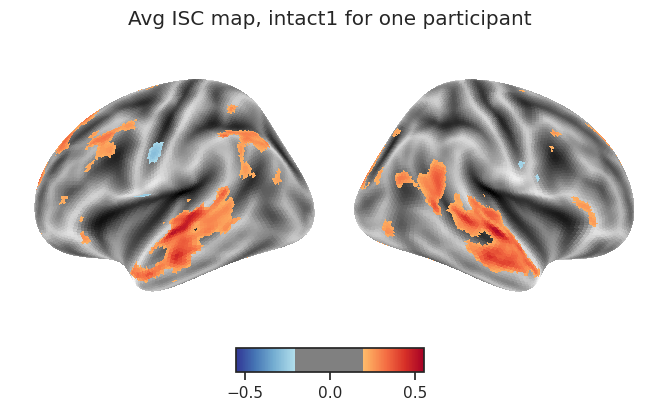

In [16]:
# Set some plotting parameters. 
subj_id = 0 
task_name = 'intact1'
threshold = .2 
view = 'lateral'


# Make the ISC output a volume
isc_vol = np.zeros(brain_nii.shape)
# Map the ISC data for the first participant into brain space
isc_vol[coords] = isc_maps[task_name][subj_id, :]
# Make a nii image of the isc map 
isc_intact_1subj = nib.Nifti1Image(isc_vol, brain_nii.affine, brain_nii.header)


# Plot 
title_text = (f'Avg ISC map, {task_name} for one participant')

_=plotting.plot_img_on_surf(isc_intact_1subj, views=[view], # this shows only the lateral view
                              title=title_text,
                              inflate=True, 
                              alpha=1, darkness=1, cmap='RdYlBu_r',
                              threshold=threshold)


**Exercise 3:** <a id="ex3"></a> Visualize the averaged ISC map across all held-out participants on the surface for both conditions and both the medial and lateral views. Make sure you use the same threshold (0.2) and vmax (0.6) for all plots, and add titles to each plot. 

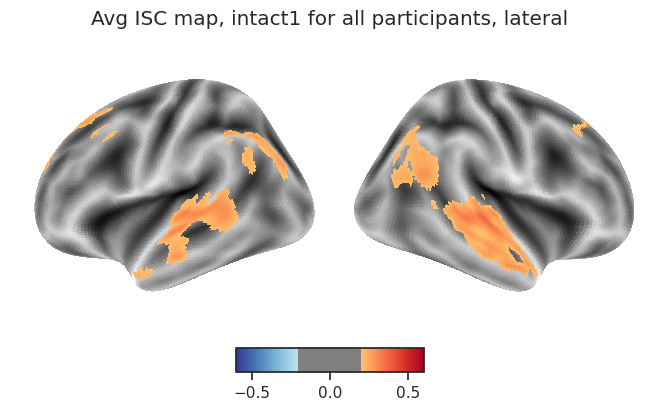

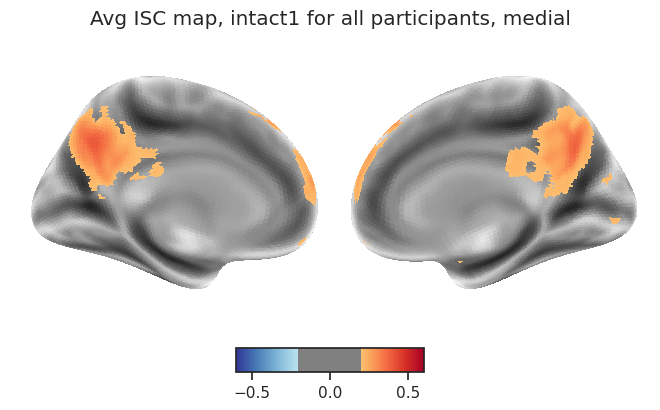

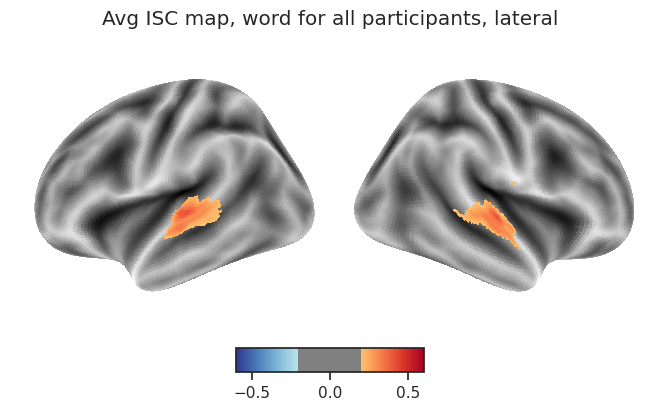

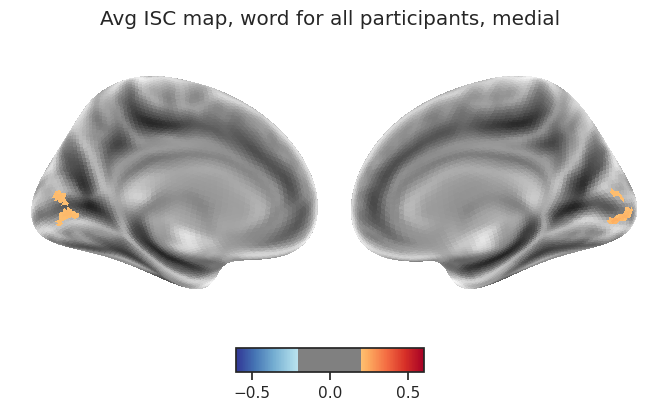

In [17]:
# # Insert code here

task_name = 'intact1'
threshold = .2 
view = 'lateral'


# Make the ISC output a volume
isc_vol = np.zeros(brain_nii.shape)
# Map the ISC data for the first participant into brain space
isc_vol[coords] = np.mean(isc_maps[task_name],0)
# Make a nii image of the isc map 
isc_intact_1subj = nib.Nifti1Image(isc_vol, brain_nii.affine, brain_nii.header)


# Plot 
title_text = (f'Avg ISC map, {task_name} for all participants, {view}')

_=plotting.plot_img_on_surf(isc_intact_1subj, views=[view], # this shows only the lateral view
                              title=title_text,
                              inflate=True, 
                              alpha=1, darkness=1, cmap='RdYlBu_r', vmax = 0.6,
                              threshold=threshold)

task_name = 'intact1'
threshold = .2 
view = 'medial'


# Make the ISC output a volume
isc_vol = np.zeros(brain_nii.shape)
# Map the ISC data for the first participant into brain space
isc_vol[coords] = np.mean(isc_maps[task_name],0)
# Make a nii image of the isc map 
isc_intact_1subj = nib.Nifti1Image(isc_vol, brain_nii.affine, brain_nii.header)


# Plot 
title_text = (f'Avg ISC map, {task_name} for all participants, {view}')

_=plotting.plot_img_on_surf(isc_intact_1subj, views=[view], # this shows only the lateral view
                              title=title_text,
                              inflate=True, 
                              alpha=1, darkness=1, cmap='RdYlBu_r', vmax = 0.6,
                              threshold=threshold)

task_name = 'word'
threshold = .2 
view = 'lateral'


# Make the ISC output a volume
isc_vol = np.zeros(brain_nii.shape)
# Map the ISC data for the first participant into brain space
isc_vol[coords] = np.mean(isc_maps[task_name],0)
# Make a nii image of the isc map 
isc_intact_1subj = nib.Nifti1Image(isc_vol, brain_nii.affine, brain_nii.header)


# Plot 
title_text = (f'Avg ISC map, {task_name} for all participants, {view}')

_=plotting.plot_img_on_surf(isc_intact_1subj, views=[view], # this shows only the lateral view
                              title=title_text,
                              inflate=True, 
                              alpha=1, darkness=1, cmap='RdYlBu_r', vmax = 0.6,
                              threshold=threshold)

task_name = 'word'
threshold = .2 
view = 'medial'


# Make the ISC output a volume
isc_vol = np.zeros(brain_nii.shape)
# Map the ISC data for the first participant into brain space
isc_vol[coords] = np.mean(isc_maps[task_name],0)
# Make a nii image of the isc map 
isc_intact_1subj = nib.Nifti1Image(isc_vol, brain_nii.affine, brain_nii.header)


# Plot 
title_text = (f'Avg ISC map, {task_name} for all participants, {view}')

_=plotting.plot_img_on_surf(isc_intact_1subj, views=[view], # this shows only the lateral view
                              title=title_text,
                              inflate=True, 
                              alpha=1, darkness=1, cmap='RdYlBu_r', vmax = 0.6,
                              threshold=threshold)

**Exercise 4:** <a id="ex4"></a> Compare the averaged ISC map for the two task conditions. What are some brain regions showing stronger correlation in the intact story condition (vs. the word-level scramble condition)? What does this tell us about the processing of language? 

Hint: There's a few papers that discuss this type of contrast; this [paper](https://doi.org/10.1523/JNEUROSCI.3684-10.2011) may help.

**A:**
On average, intact stories cause higher levels of activity in the sensory speech area and parietal lobe in addition to the activity in the auditory cortext. In comparison, the word-level scramble solely shows activity in the auditory cortex and minimal activation in the sensory speech area. This makes sense as the intact narrative demands higher order thinking and understanding of complex ideas that are expressed through chains of words in comparison to the meaningless auditory stimulation in the word-scrambled version.

### 2.4 ISC with statistical tests  <a id="isc_stats"></a>

BrainIAK provides several nonparametric statistical tests for ISC analysis ([Nastase et al., 2019](https://academic.oup.com/scan/article/14/6/667/5489905)). Nonparametric tests are preferred due to the inherent correlation structure across ISC values—each subject contributes to the ISC of other subjects, violating assumptions of independence required for standard parametric tests (e.g., t-test, ANOVA). We will use the permutation test below.
*Additional resources on parametric versus nonparametric statistics [here](https://www.ibm.com/docs/en/db2woc?topic=nonparametric-background)*.

#### 2.4.1 Permutation test
Permutation tests are used to compute a null distribution of values. We have used permutation tests in previous notebooks and the steps outlined here are similar to what was done in prior notebooks with one small change, incorporating the group of subjects to compute the ISC:

1. Prepare the data. Here we have two conditions (intact and word_scramble), so we compute ISC for both conditions and concatenate the data for these two conditions for all subjects.  
> We use leave-one-subject-out (`pairwise=False`) to compute ISC and then use the correlations in  `isc_maps_all_tasks` to compute statistics.  

2. We are going to permute the condition label for each subject to simulate the randomization of conditions. To do this, we first need to assign subjects to the correct experimental conditions that they were in. We have prepared such a list of assignments when we loaded the data and stored the information in the variable: `group_assignment`.
 
3. The next steps are executed internally in BrainIAK in the function `permutation_isc`:    
> - For each permutation iteration: 
>> - BrainIAK permutes the group assignment for each subject.  
>> - A mean of the ISC values is then computed for this shuffled 
group for each condition.   
>> -  A difference of group means is computed between each condition.  
> - The difference values for all iterations is collected and forms the null distribution.   
4. Finally, we pick a threshold value that corresponds to `p` percent of this distribution.  

`permutation_isc` returns the actual observed ISC values, p-values, and optionally the null distribution.

In [18]:
# Concatenate ISCs from both tasks
isc_maps_all_tasks = np.vstack([isc_maps[task_name] for
                                task_name in all_task_names])

print(f'group_assignment: {group_assignment}')
print(f'isc_maps_all_tasks: {np.shape(isc_maps_all_tasks)}')

group_assignment: [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1]
isc_maps_all_tasks: (18, 98508)


In [19]:
# Run permutation tests with Brainiak
n_permutations = 1000 # Normally you'd run 10**3 or 10**4 permutations.
summary_statistic='median' # Compare to the median of the distribution

observed, p, distribution = permutation_isc(
    isc_maps_all_tasks, 
    pairwise=False,
    group_assignment=group_assignment, 
    summary_statistic=summary_statistic,
    n_permutations=n_permutations
)

In [20]:
print(observed.shape)

(98508,)


In [21]:
print(p.shape)

(98508,)


In [22]:
print(distribution.shape)

(1000, 98508)


**Exercise 5:** <a id="ex5"></a> Explain the logic of this permutation test. What is being permuted? What question does the permutation test answer?

**A:**
There is a necessity for some degree of randomization in order to ensure that we produce a null distribution for every voxel without any assumption that the task condition affects IS Correlations. This distribution is used to determine the p value for the observed value we get for each voxel, allowing us to determine significance. We permute the condition label across each permutation so that we may determine the chance that the observed differences we see between correlation values in observed will be at least as big as we see occur.

**Exercise 6:** <a id="ex6"></a> Interpret the results of the permutation test. 
- What are the outputs `observed`, `p`, `distribution`? Interpret what these three outputs mean, then visualize `observed` and `p` on the brain (any plotting type is fine).
- How many voxels are significant at p < 0.01?

**A:**
observed is the actual value of the difference between the observed IS Correlation for the two conditions, it is an array. p is the array of p values for each voxel determined by the permutation test. distribution is the distribution of the null ISC values for each permutation for each voxel (1000 by 98508).

Text(0.5, 1.0, 'p ISC: p < 0.01')

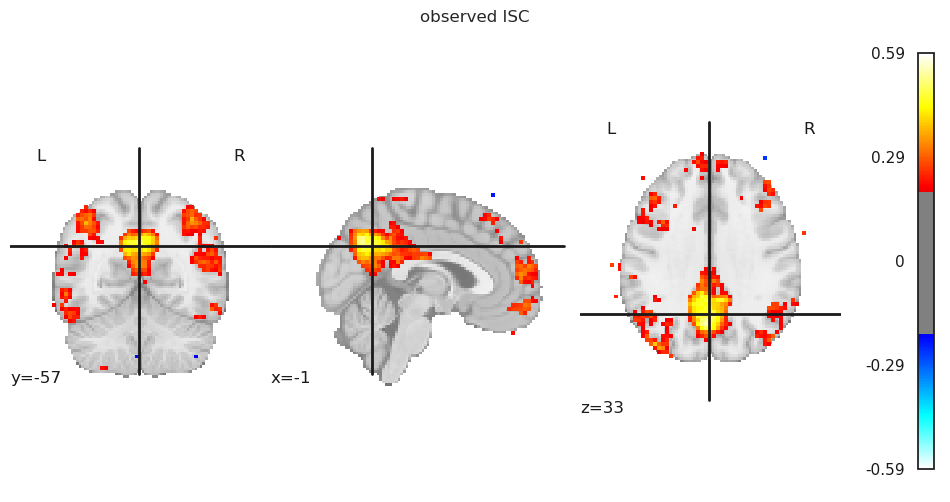

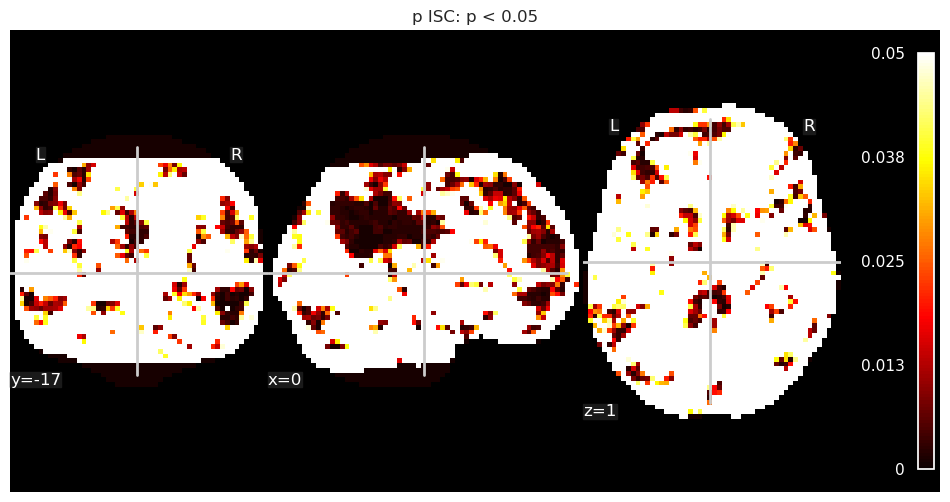

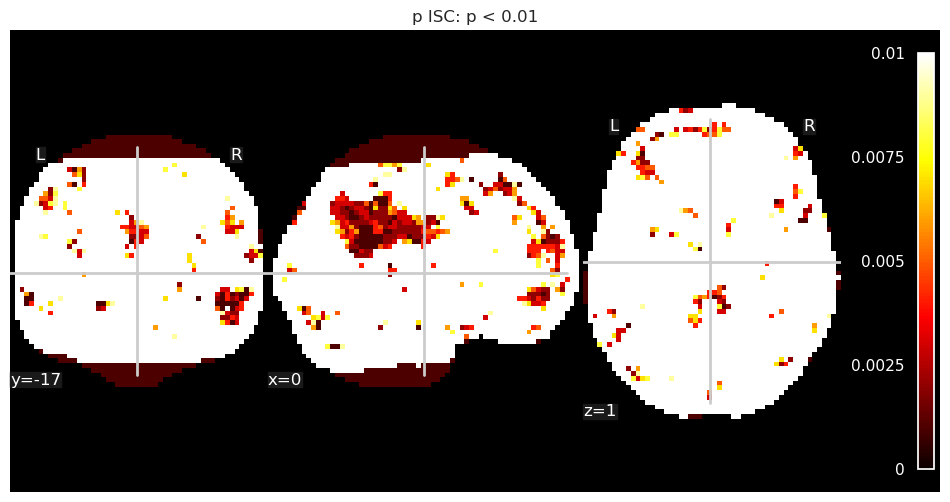

In [23]:
isc_vol_obs = np.zeros(brain_nii.shape)
isc_vol_obs[coords] = observed
isc_nifti_obs = nib.Nifti1Image(isc_vol_obs, brain_nii.affine, brain_nii.header)

f, ax = plt.subplots(1,1,figsize=(12,6))
plotting.plot_stat_map(
    isc_nifti_obs,
    threshold = threshold,
    axes = ax
)

ax.set_title('observed ISC')


isc_vol_p = np.zeros(brain_nii.shape)
isc_vol_p[coords] = p
isc_nifti_p = nib.Nifti1Image(isc_vol_p, brain_nii.affine, brain_nii.header)

f, ax = plt.subplots(1,1,figsize=(12,6))
plotting.plot_stat_map(
    isc_nifti_p,
    isc_nifti_p,
    vmax = 0.05,
    axes = ax
)

ax.set_title('p ISC: p < 0.05')

isc_vol_p = np.zeros(brain_nii.shape)
isc_vol_p[coords] = p
isc_nifti_p = nib.Nifti1Image(isc_vol_p, brain_nii.affine, brain_nii.header)

f, ax = plt.subplots(1,1,figsize=(12,6))
plotting.plot_stat_map(
    isc_nifti_p,
    isc_nifti_p,
    vmax = 0.01,
    axes = ax
)

ax.set_title('p ISC: p < 0.01')

In [24]:
print(f'the number of significant voxels is: {np.sum(p < 0.01)}')

the number of significant voxels is: 19149


## 3. ISFC  <a id="isfc"></a>

The goal of ISFC is to find coupling between brain regions across participants. For example, the angular gyrus in subject 1 could be correlated to the pre-frontal cortex in subject 2, if they share some cognitive state. For completely random cognitive states across these two subjects, the correlation should be zero. ISFC helps us identify such commonalities across subjects.

In this section, we will compare functional connectivity vs. ISFC on the Pieman data. Whereas FC is computed within individuals, ISFC is computed between individuals. Hence the only correlations that should be robust in ISFC are those that are present across individuals. At the end of the exercises, you will qualitatively replicate [Simony et al. (2016)](https://doi.org/10.1038/ncomms12141), showing that ISFC is sensitive to the cognitive state of the participants.

### 3.1 Parcellate the data  <a id="isfc_parcel"></a>

ISFC in voxel space is very computationally intensive (remember how long FCMA was estimated to take!), so for this notebook we will divide the brain into a smaller number of parcels. We are going to use predefined ROI masks to select the voxels.

Number of voxels:	 (98508, 9)
Number of parcels:	 96


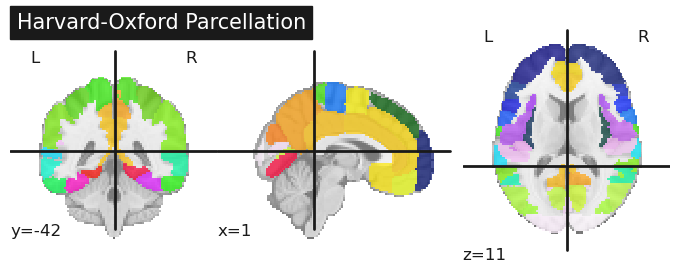

In [25]:
# Load a parcellation
atlas = datasets.fetch_atlas_harvard_oxford('cort-maxprob-thr25-2mm', symmetric_split=True)
plotting.plot_roi(atlas.maps, title='Harvard-Oxford Parcellation')

n_regions = len(atlas.labels)-1 # rm background region 
n_TRs = np.shape(bold[task_name])[0]

print(f'Number of voxels:\t {np.shape(bold[task_name][1])}')
print(f'Number of parcels:\t {n_regions}')

Convert the bold data into ROI parcels.

In [26]:
# Get a masker for the atlas. 
masker_HarOxf = NiftiLabelsMasker(labels_img=atlas.maps)

# Transform the data to the parcel space.
bold_HarOxf = {
    task_name:np.zeros((n_TRs, n_regions, n_subjs[task_name])) 
    for task_name in all_task_names}

# Collect all data. 
row_has_nan = np.zeros(shape=(n_regions,), dtype=bool)
for task_name in all_task_names:
    for subj_id in range(n_subjs[task_name]):
        
        # Get the data for task t, subject s.
        nii_t_s = nib.load(fnames[task_name][subj_id])
        bold_HarOxf[task_name][:,:,subj_id] = masker_HarOxf.fit_transform(nii_t_s)
        
        # Figure out missing rois.
        row_has_nan_ = np.any(np.isnan(bold_HarOxf[task_name][:,:,subj_id]),axis=0)
        row_has_nan[row_has_nan_] = True                

# Figure out which ROI has missing values.
roi_select = np.logical_not(row_has_nan)
n_roi_select = np.sum(roi_select)
rois_filtered = np.array(atlas.labels[1:])[roi_select]
bold_HarOxf_filtered = {
    task_name:np.zeros((n_TRs, n_roi_select, n_subjs[task_name])) 
    for task_name in all_task_names
}

# Remove ROIs with missing values.
for task_name in all_task_names:
    for subj_id in range(n_subjs[task_name]):
        bold_HarOxf_filtered[task_name][:,:,subj_id] = bold_HarOxf[task_name][:,roi_select,subj_id]
              
print(f'ROI selected: \n {rois_filtered}')
print(f'ROI removed due to missing values: \n {np.array(atlas.labels[1:])[row_has_nan]}')

ROI selected: 
 ['Left Frontal Pole' 'Right Frontal Pole' 'Left Insular Cortex'
 'Right Insular Cortex' 'Left Superior Frontal Gyrus'
 'Right Superior Frontal Gyrus' 'Left Middle Frontal Gyrus'
 'Right Middle Frontal Gyrus'
 'Left Inferior Frontal Gyrus, pars triangularis'
 'Right Inferior Frontal Gyrus, pars triangularis'
 'Left Inferior Frontal Gyrus, pars opercularis'
 'Right Inferior Frontal Gyrus, pars opercularis' 'Left Precentral Gyrus'
 'Right Precentral Gyrus' 'Left Temporal Pole' 'Right Temporal Pole'
 'Left Superior Temporal Gyrus, anterior division'
 'Right Superior Temporal Gyrus, anterior division'
 'Left Superior Temporal Gyrus, posterior division'
 'Right Superior Temporal Gyrus, posterior division'
 'Left Middle Temporal Gyrus, anterior division'
 'Right Middle Temporal Gyrus, anterior division'
 'Left Middle Temporal Gyrus, posterior division'
 'Right Middle Temporal Gyrus, posterior division'
 'Left Middle Temporal Gyrus, temporooccipital part'
 'Right Middle Tempora

### 3.2 Compute FC and ISFC  <a id="fc_isfc"></a>

Here we compute FC and ISFC on the parcellated data. 

In [27]:
# Compute FC
fc_maps_HarOxf = {
    task_name:np.zeros((n_roi_select,n_roi_select)) 
    for task_name in all_task_names
}

# Loop through task names
for task_name in all_task_names: 
    # Loop through the subjects
    for subj_id in range(n_subjs[task_name]):
        # The FC map for a given task & subject is the correlation between all regions' bold data, for that task
        
        fc_maps_HarOxf[task_name] += np.corrcoef(
            bold_HarOxf_filtered[task_name][:,:,subj_id].T
        )
    fc_maps_HarOxf[task_name] /= n_subjs[task_name] # now average over the number of subjects
    np.fill_diagonal(fc_maps_HarOxf[task_name], np.nan) # and make sure the diagonal is irrelevant    

In [28]:
# Compute ISFC
isfc_maps_HarOxf = {}
for task_name in all_task_names:
    isfc_maps_HarOxf[task_name] = isfc(data=bold_HarOxf_filtered[task_name],
                                   summary_statistic='median',
                                   vectorize_isfcs=False)   

In [29]:
all_task_names

['intact1', 'word']

**Exercise 7:** <a id="ex7"></a> Visualize the FC & ISFC matrices for each condition, averaged across subjects. Mark the rows & columns with the ROI labels and clearly label the matrices. What do you notice about the FC versus ISFC matrices?

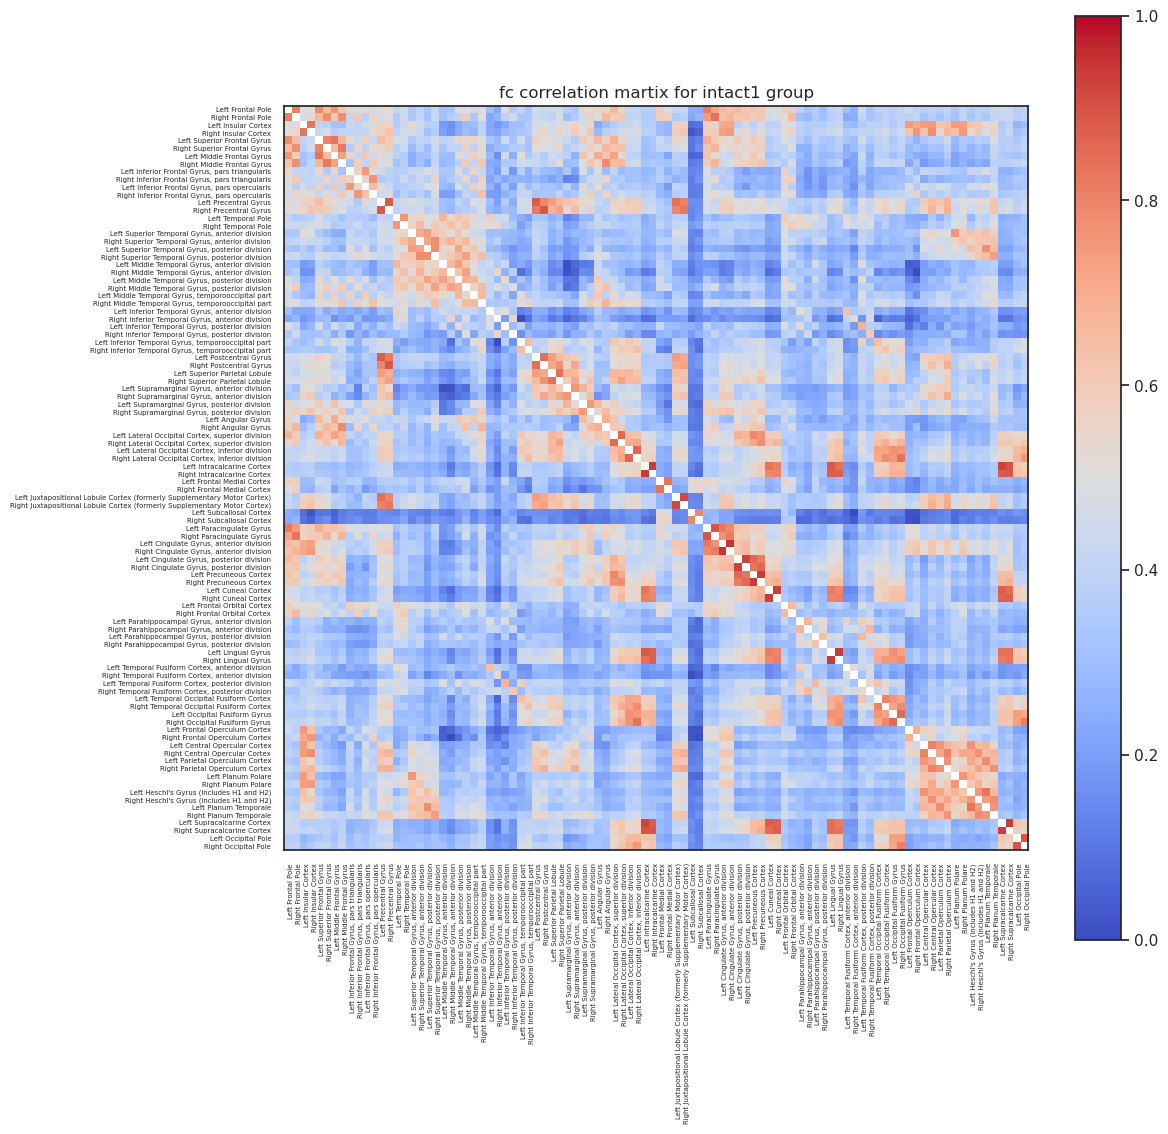

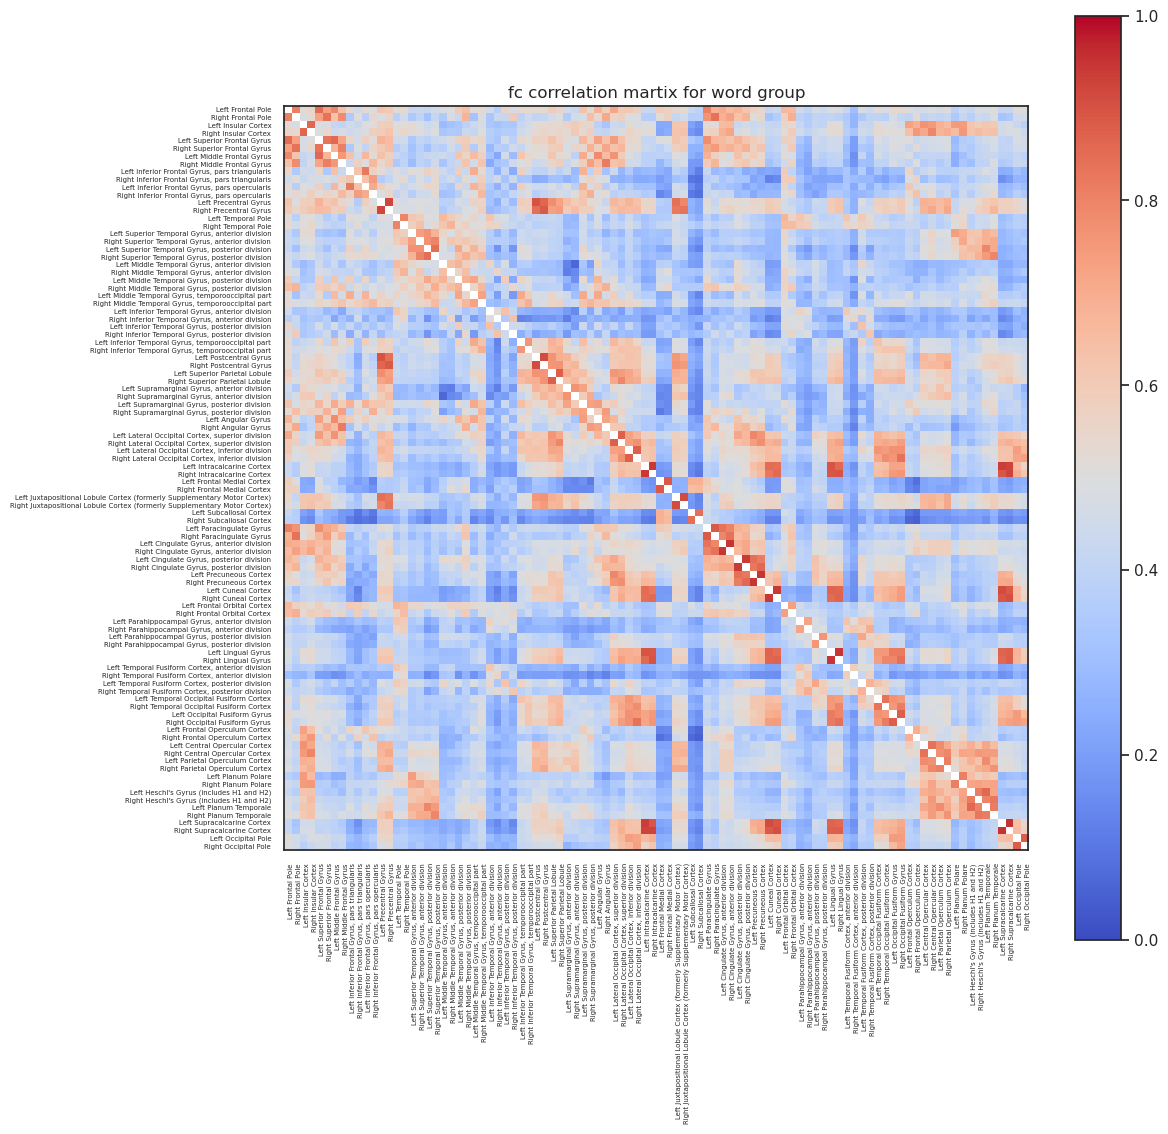

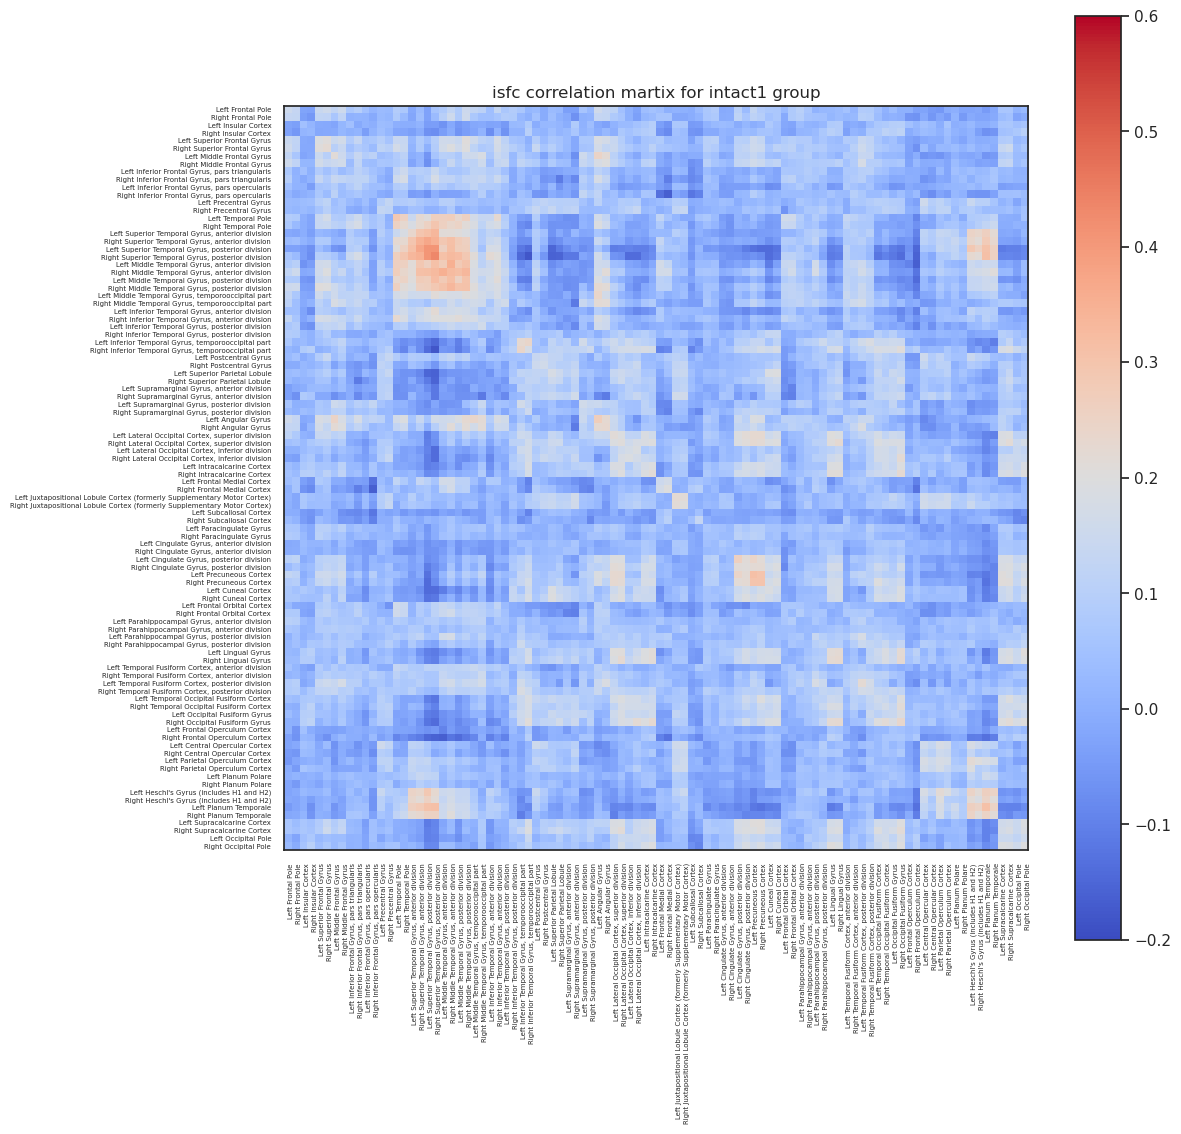

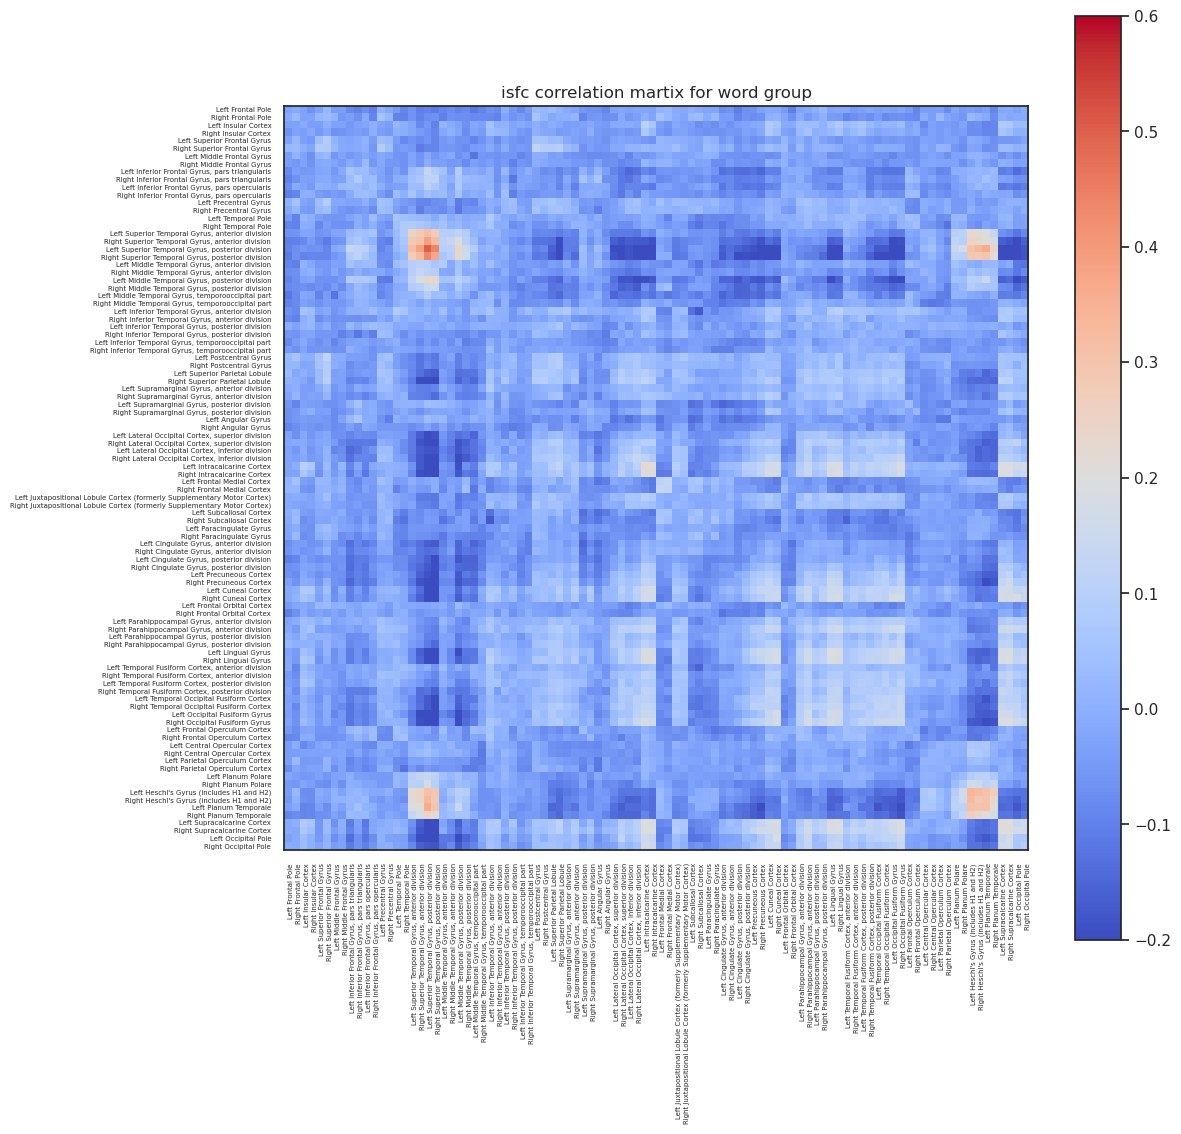

In [30]:
# Insert code here

corrdict = {"fc":fc_maps_HarOxf, "isfc": isfc_maps_HarOxf}
    
for fctype in ["fc","isfc"]:
    for task_name in all_task_names:
        corrmat = corrdict[fctype][task_name]
        fig, ax = plt.subplots(figsize = (12,12))
        
        if fctype == "fc":
            im = ax.imshow(corrmat, cmap="coolwarm", vmin = 0, vmax = 1)
        else:
            im = ax.imshow(corrmat, cmap="coolwarm", vmin = -0.2, vmax = 0.6)
        
        cbar = ax.figure.colorbar(im,ax=ax)
        
        ax.set_xticks(np.arange(len(rois_filtered)))
        ax.set_yticks(np.arange(len(rois_filtered)))
        ax.set_xticklabels(rois_filtered, fontsize = 5)
        ax.set_yticklabels(rois_filtered, fontsize = 5)
        
        ax.set_title(f'{fctype} correlation martix for {task_name} group')
        
        plt.setp(ax.get_xticklabels(), rotation=90, ha='right', rotation_mode = "anchor")
        
        plt.show()

**Exercise 8:** <a id="ex7"></a> Visualize FC/ISFC connectivity strength on glass brains using `plot_connectome` to visualize the same 4 matrices as in exercise 7. Use the a common `edge_threshold` for all plots.

*Hint:* The plot_connectome function takes as an input a correlation matrix (such as the FC one plotted above) and also a set of coordinates that define the XYZ coordinates that corresponds to each column/row of the correlation matrix `node_coords`. In order to get the coordinates of these ROIs, we recommend you use: `plotting.find_parcellation_cut_coords(atlas.maps)[roi_select]`  

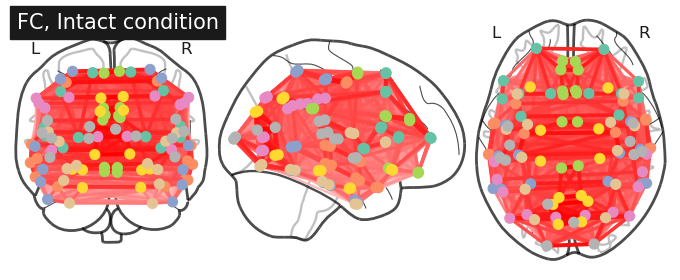

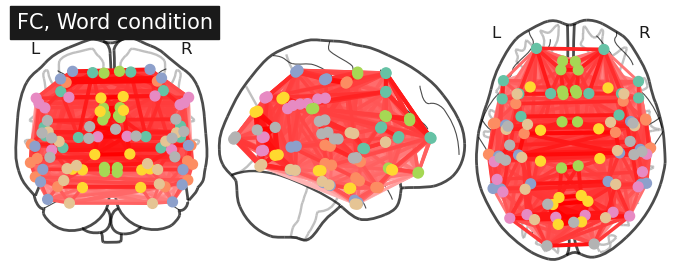

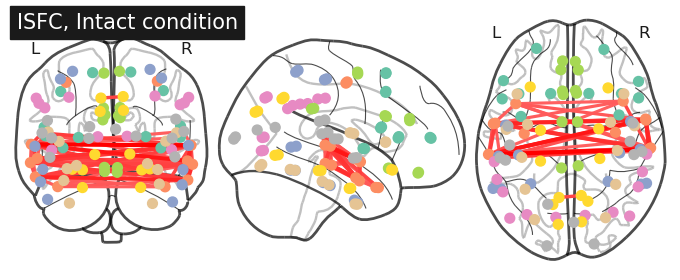

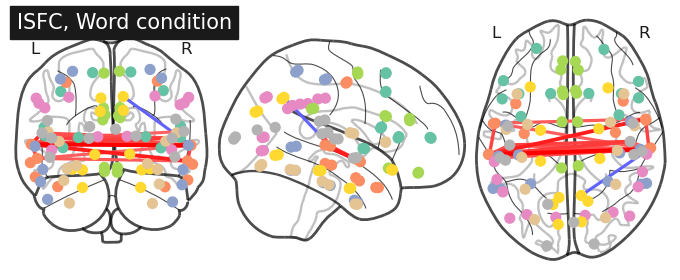

In [31]:
cut_coords_all = plotting.find_parcellation_cut_coords(atlas.maps)[roi_select]

plotting.plot_connectome (fc_maps_HarOxf['intact1'],
    node_coords = cut_coords_all,
    edge_threshold = 0.25,
    title='FC, Intact condition')

plotting.plot_connectome(fc_maps_HarOxf['word'],
    node_coords = cut_coords_all,
    edge_threshold = 0.25,
    title='FC, Word condition')

plotting.plot_connectome (isfc_maps_HarOxf['intact1'],
    node_coords = cut_coords_all,
    edge_threshold = 0.25,
    title='ISFC, Intact condition')

plotting.plot_connectome(isfc_maps_HarOxf['word'],
    node_coords = cut_coords_all,
    edge_threshold = 0.25,
    title='ISFC, Word condition')

**Exercise 9:** <a id="ex9"></a> Do FC maps look different across conditions? How about ISFC? Why?

**A:** 
The FC maps look similar to one another across conditions and apparently have a lot of noise whereas the isfc appears to be much more clear and de-noised. This is likely because FC is solely within one subject and does not, like ISFC, only look at the correlations that exist across all the subjects, selecting for only the ones that matter for the purpose of the study. Hence it makes sense that there would be clearer differences in ISFC. ISFC shows that the intact group tends to have slightly more correlation among certain areas such as the middle temporal gyri and the left and right precueneous cortexes.

In addition, in ISFC, the two conditions are slightly different in that intact condition nets additional correlations as the auditory cortex links to and correlates with higher order processing of ideas in the story as seen in the glass brains and matrices, with more regions being connected because of this.

## 4. Spatial pattern correlation across subjects <a id="spat_corr"></a>


### 4.1 Spatial inter-subject correlation  <a id="spatial_isc"></a>

We can apply the idea of inter-subject analysis to RSA. So far, ISC is being computed between aligned pairs of voxels across time points and it is commonly referred to as temporal ISC. However, we could instead correlate aligned pairs of time points across voxels. That is, how does the pattern of activity across voxels for one time point correlate with the average voxel pattern of the other participants at that time point. By doing this for each time point, we can generate a time course of these correlations to observe the general ebb and flow of coupling in brain activity across participants. This can be done simply by transposing the voxel and time dimensions (for a 3-D matrix, this is accomplished with a 90 degree rotation). If we have data in the format: (TRs, voxels, subjects), we can use `data.transpose(1,0,2)`, where the indices refer to the dimensions of the array and we will have an array in the format (voxels, TRs, subjects).

#### Compare the two task conditions with spatial ISC 

One way to compare the intact and word_scramble conditions is to plot the correlation values, by TR, for each condition. Again, we can use the same ISC functions from above after transposing the data matrices. 

In [32]:
# Get a list of ROIs. 
roi_mask_path = os.path.join(pieman2_dir,'masks','rois')
all_roi_fpaths = glob.glob(os.path.join(roi_mask_path, '*.nii'))

# Collect all ROIs 
all_roi_names = []
all_roi_nii = {}
all_roi_masker = {}
for roi_fpath in all_roi_fpaths:
    
    # Compute ROI name
    roi_fname = os.path.basename(roi_fpath)
    roi_name = roi_fname.split('.')[0]
    all_roi_names.append(roi_name)
    
    # Load roi nii file 
    roi_nii = nib.load(roi_fpath)
    all_roi_nii[roi_name] = roi_nii
    
    # Make roi maskers
    all_roi_masker[roi_name] = NiftiMasker(mask_img=roi_nii)

print(f'Path to all roi masks: {roi_mask_path}')    
print(f'Here are all ROIs:\n{all_roi_names}')

Path to all roi masks: /gpfs/gibbs/project/cmhn/data/Pieman2/masks/rois
Here are all ROIs:
['HG_R', 'V1', 'dMFG_R', 'vPCUN', 'vV2', 'dPCUN', 'aSTG_L', 'dMFG_L', 'STC_L', 'PMC_L', 'IPL_L', 'hV4_R', 'SMA_L', 'pMTS_L', 'SFG', 'aPFC', 'dPCC', 'cMTG_R', 'dPoCS_L', 'dPoCS_R', 'DLPFC_L', 'hV4_L', 'ldV2_L', 'pANG_R', 'Insular_L', 'SOG_L', 'IPL_R', 'aOFC_R', 'MCC', 'dmPFG', 'pMTG_R', 'HG_L', 'LOC_L', 'aANG_R', 'V3a_L', 'DLPFC_R', 'vPFC_R', 'lOFG_R', 'pIFG_L', 'vmPFC', 'STC_R', 'vMFG_L', 'dPreCG_L', 'SMG_L', 'aMTG_R', 'LOC_R', 'aIFG_L', 'aCUN', 'Insular_R', 'aOFC_L', 'SFS_L', 'pMTS_R', 'V3a_R', 'SMG_R', 'V3', 'pANG_L', 'aIFG_R', 'caMTG_L', 'aANG_L', 'mldV2_R', 'aINS_L', 'smPFC', 'lOFG_L']


In [33]:
# Make a function to load data for one ROI
def load_roi_data(roi_name, fnames): 
    # Pick a ROI masker.
    roi_masker = all_roi_masker[roi_name]    
    
    # Preallocate. 
    bold_roi = {task_name:[] for i, task_name in enumerate(all_task_names)}
    
    # Gather data. 
    for task_name in all_task_names:
        for subj_id in range(n_subjs[task_name]):
            
            # Get the data for task t, subject s 
            nii_t_s = nib.load(fnames[task_name][subj_id])
            bold_roi[task_name].append(roi_masker.fit_transform(nii_t_s))
            
        # Reformat the data to std form 
        bold_roi[task_name] = np.transpose(np.array(bold_roi[task_name]), [1,2,0])
    return bold_roi

Compute spatial ISC on some ROIs. 

In [34]:
roi_selected = ['dPCC', 'vPCUN', 'V1']
roi_selected_names = ['dorsal posterior cingulate cortex', 'ventral precuneus', 'primary visual cortex']

# compute spatial ISC for all ROIs 
iscs_roi_selected = []
for j, roi_name in enumerate(roi_selected):
    print(j, roi_name)
    
    # Load data 
    bold_roi = load_roi_data(roi_name, fnames)
    
    # Compute ISC 
    iscs_roi = {}
    for task_name in all_task_names: 
        iscs_roi[task_name] = isc(np.transpose(bold_roi[task_name], [1,0,2]))
        
    iscs_roi_selected.append(iscs_roi)

0 dPCC
1 vPCUN
2 V1


Text(0.5, 0, 'TRs')

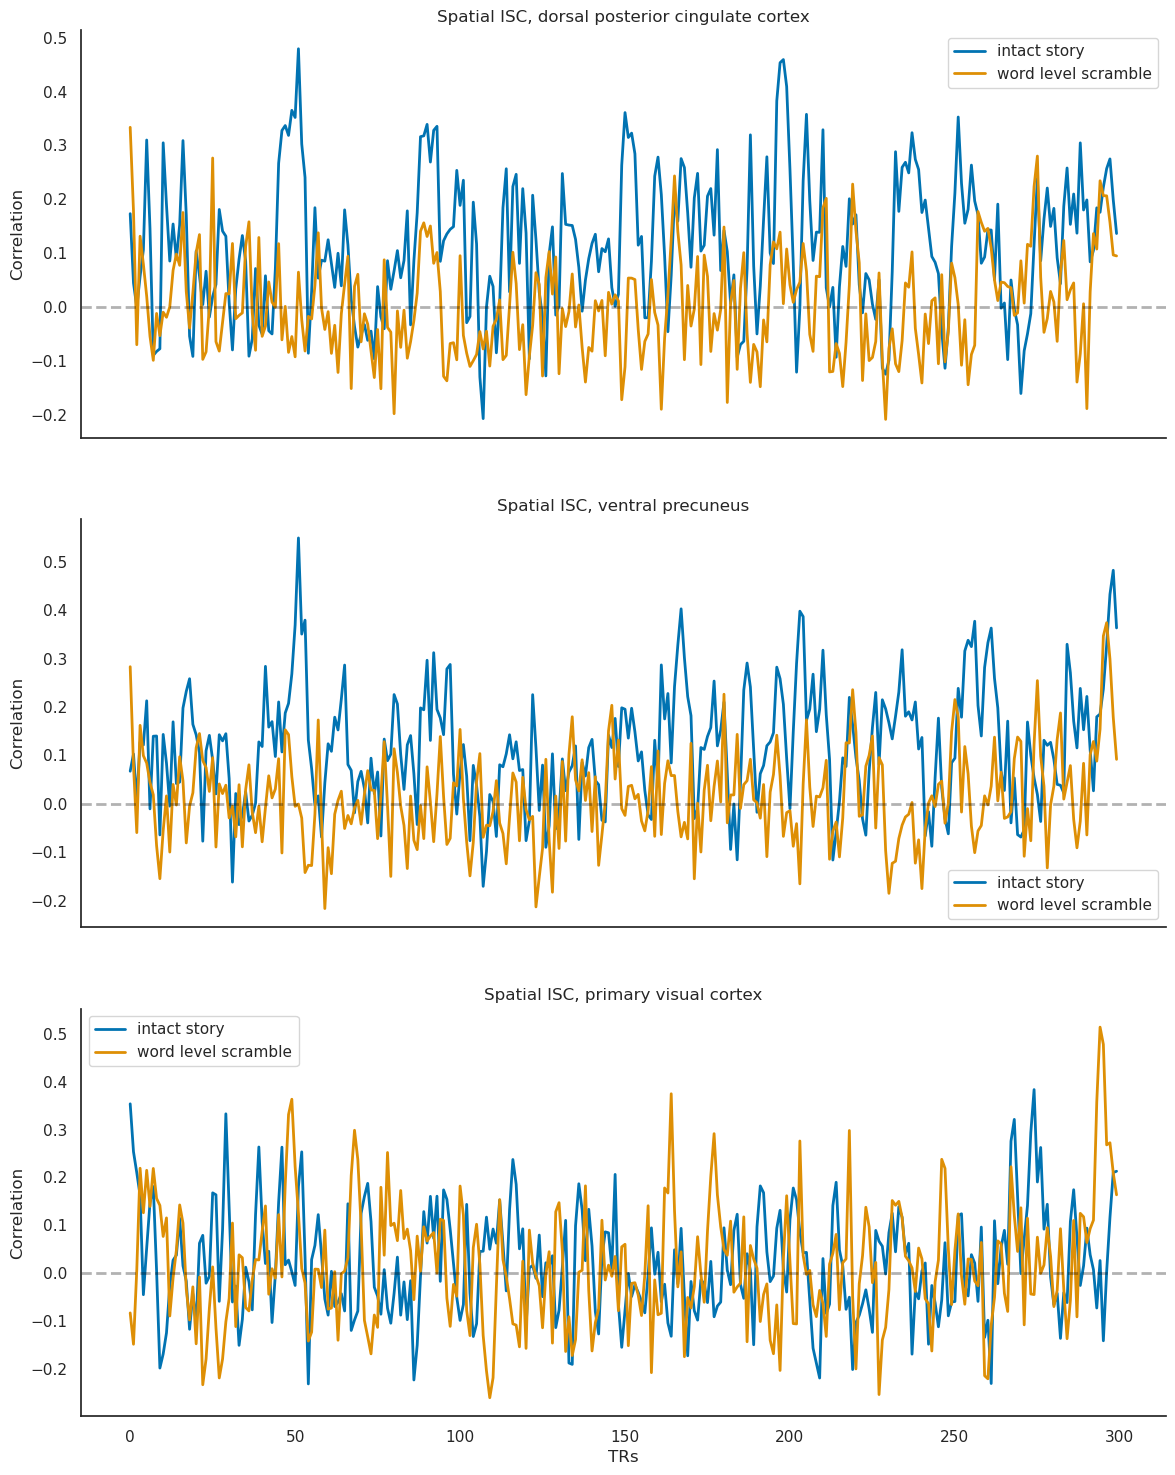

In [35]:
# Plot the spatial ISC over time
col_pal = sns.color_palette(palette='colorblind', n_colors=len(all_task_names))

f, axes = plt.subplots(len(roi_selected), 1, figsize=(14, 6 * len(roi_selected)), sharex=True)

# For each ROI
for j, roi_name in enumerate(roi_selected):
    # For each task 
    for i, task_name in enumerate(all_task_names): 
        axes[j].plot(
            np.mean(iscs_roi_selected[j][task_name],axis=0), 
            color=col_pal[i], 
        )
    sns.despine()

# Label the plot 
for j, roi_name in enumerate(roi_selected):
    axes[j].axhline(0, color='black', linestyle='--', alpha=.3)
    axes[j].set_ylabel('Correlation')
    axes[j].set_title('Spatial ISC, {}'. format(roi_selected_names[j]))
    axes[j].legend(all_task_des)    
    
axes[-1].set_xlabel('TRs')

**Exercise 10:**<a id="ex10"></a> Interpret the spatial ISC results you observed above and what you can conclude from this type of analysis.

**A:**
In the spatial ISC for the prefrontal cortex and the ventral precuneus, the vast majority of time points show higher correlation between the pattern of activity with the average patterns of activity in other participants for the the intact story as compared to the word level scramble. This is likely because the intact story allows for people to have the same higher order ideas and images conveyed through them through meaningful audio, causing different people to have activity correlations in particular higher order thinking brain areas at the same times as the narrative unfolds whereas those thoughts do not occur in the scrambled audio scenario.

The spatial ISC for the primary visual cortex, although largely random, shows spikes in correlation at certain time points for both the intact story and word level scramble. We do see however that during the middle and end of the time series, in the midst of the narrative, correlations in visual cortex lower in the intact story group, likely since they became absorbed by the story and were not looking at things in the machine. The scrambled story group was perhaps distracted or drawn to look at similar things within the mri and due to lack of engagement or meaning in the audio, were likely more drawn to looking at things, causing increased visual cortex correlation in certain spikes.

**Novel contribution:**<a id="novel"></a> be creative and make one new discovery by adding an analysis, visualization, or optimization.


0 vmPFC
1 dmPFG


Text(0.5, 0, 'TRs')

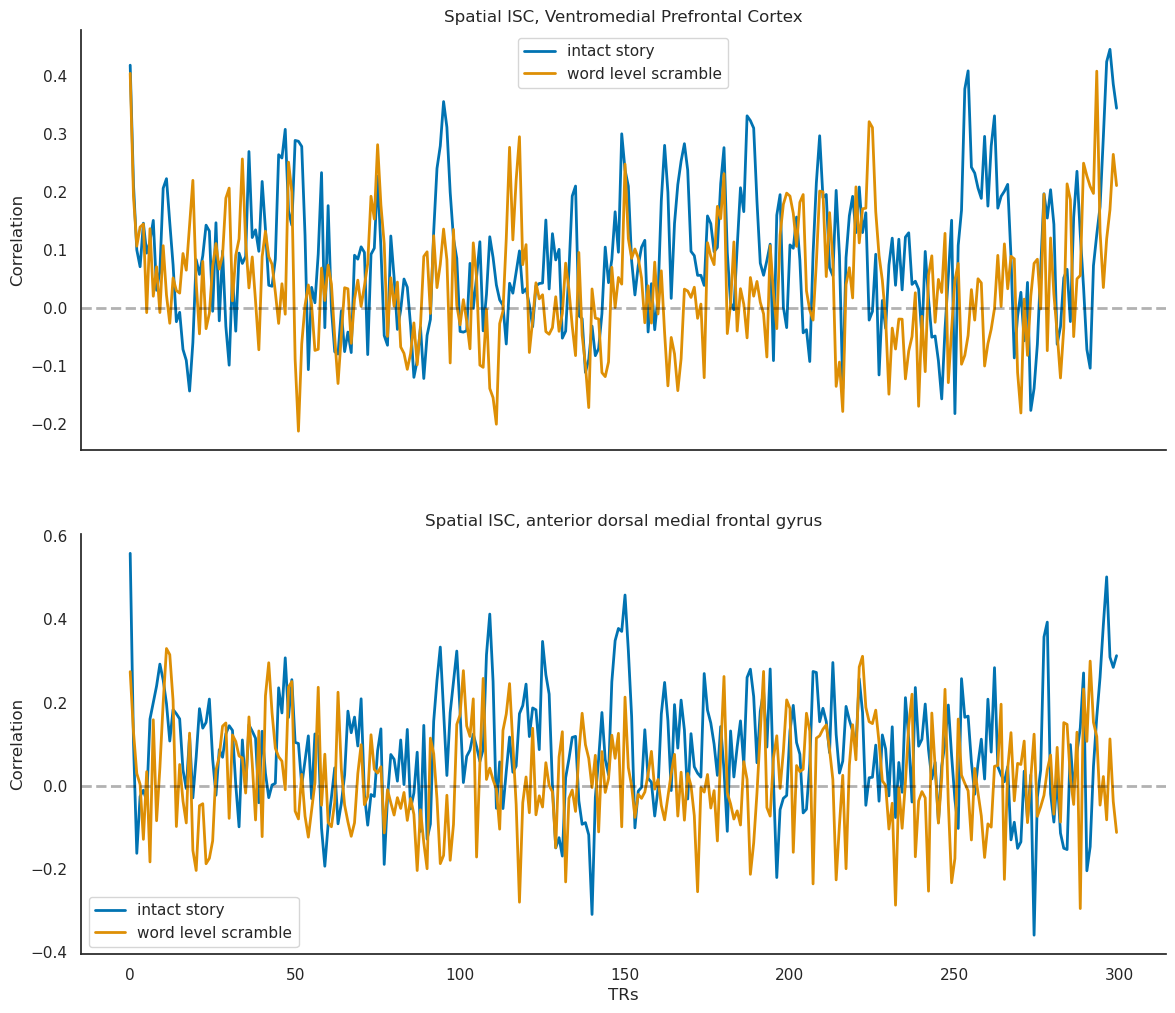

In [36]:
# Code here

roi_selected = ['vmPFC', 'dmPFG']
roi_selected_names = ['Ventromedial Prefrontal Cortex', 'anterior dorsal medial frontal gyrus']

# compute spatial ISC for all ROIs 
iscs_roi_selected = []
for j, roi_name in enumerate(roi_selected):
    print(j, roi_name)
    
    # Load data 
    bold_roi = load_roi_data(roi_name, fnames)
    
    # Compute ISC 
    iscs_roi = {}
    for task_name in all_task_names: 
        iscs_roi[task_name] = isc(np.transpose(bold_roi[task_name], [1,0,2]))
        
    iscs_roi_selected.append(iscs_roi)
    

# Plot the spatial ISC over time
col_pal = sns.color_palette(palette='colorblind', n_colors=len(all_task_names))

f, axes = plt.subplots(len(roi_selected), 1, figsize=(14, 6 * len(roi_selected)), sharex=True)

# For each ROI
for j, roi_name in enumerate(roi_selected):
    # For each task 
    for i, task_name in enumerate(all_task_names): 
        axes[j].plot(
            np.mean(iscs_roi_selected[j][task_name],axis=0), 
            color=col_pal[i], 
        )
    sns.despine()

# Label the plot 
for j, roi_name in enumerate(roi_selected):
    axes[j].axhline(0, color='black', linestyle='--', alpha=.3)
    axes[j].set_ylabel('Correlation')
    axes[j].set_title('Spatial ISC, {}'. format(roi_selected_names[j]))
    axes[j].legend(all_task_des)    
    
axes[-1].set_xlabel('TRs')

The Ventromedial Prefrontal Cortex is a region said to be associated with emotional processing, decision-making, memory, self-perception, and social cognition in general. We would expect to see this have a higher correlation amids the intact story group than the word scramble group and although it is often higher, the 2nd region discussed below proved to show a larger difference between the intact and scrambled story groups.

The anterior dorsal medial frontal gyrus is stated by the article at (https://pubmed.ncbi.nlm.nih.gov/32562973/) to be related to empathy, which would likely be more correlated amongst people in the intact story group. We do indeed see relatively higher correlations in the plot for this region amongst the intact story group, as an intact story likely caused more activation of an empathy-related area of the brain.

### Contributions<a id="contributions"></a>

E. Simony and U. Hasson for providing data  
C. Baldassano and C. Chen provided initial code  
M. Kumar, C. Ellis and N. Turk-Browne produced the initial notebook 4/4/18  
S. Nastase enhanced the ISC brainiak module; added the section on statistical testing   
Q. Lu added solutions; switched to S. Nastase's ISC module; replicated Lerner et al 2011 & Simony et al. 2016; added spatial ISC.   
M. Kumar edits to section introductions and explanation on permutation test.  
K.A. Norman provided suggestions on the overall content and made edits to this notebook.  
C. Ellis incorporated edits from cmhn-s19  
Q. Lu added solutions; modified the scripts using the newest brainiak, nilearn version.      
T. Yates made edits for cmhn_s21    
E. Busch edits for cmhn s22, cmhn s23